- Data clean and visualization
- using decision tree and random forest fit models
- using K mean method to cluster all data, figure out whether 7 or 8 category is better.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  LabelEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('prosperLoanData.csv')

# 1. Data clean and visualization

### chose variables that matters

I only chooes what I believe are very important and independent.

for example, since all BorrowerAPR, EstimatedEffectiveYield, EstimatedLoss, EstimatedReturn are related or comes from the `BorrowerRate`, so I only select BorrowerRate.

In [2]:
df=data[['LoanStatus','CreditGrade','ProsperRating (Alpha)','BankcardUtilization',
       'BorrowerState','IncomeRange','LoanOriginationDate','DebtToIncomeRatio',
       'DelinquenciesLast7Years','BorrowerRate','IsBorrowerHomeowner','LoanOriginalAmount',
       'ListingCategory (numeric)','EmploymentStatus','EmploymentStatusDuration',
       'InquiriesLast6Months','CreditScoreRangeLower','CreditScoreRangeUpper']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   LoanStatus                 113937 non-null  object 
 1   CreditGrade                28953 non-null   object 
 2   ProsperRating (Alpha)      84853 non-null   object 
 3   BankcardUtilization        106333 non-null  float64
 4   BorrowerState              108422 non-null  object 
 5   IncomeRange                113937 non-null  object 
 6   LoanOriginationDate        113937 non-null  object 
 7   DebtToIncomeRatio          105383 non-null  float64
 8   DelinquenciesLast7Years    112947 non-null  float64
 9   BorrowerRate               113937 non-null  float64
 10  IsBorrowerHomeowner        113937 non-null  bool   
 11  LoanOriginalAmount         113937 non-null  int64  
 12  ListingCategory (numeric)  113937 non-null  int64  
 13  EmploymentStatus           11

In [3]:
# compute average credit score = (low + high)/2
df['CreditScore'] = (df['CreditScoreRangeLower']+df['CreditScoreRangeUpper'])/2
df.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'],axis=1,inplace=True)

In [4]:
# create Phase column in order to separete file by time
df['Phase']=None
df.loc[df['LoanOriginationDate'] >= "2009-07-01", 'Phase'] = "After"
df.loc[df['LoanOriginationDate'] < "2009-07-01", 'Phase'] = "Before"

### find variables missing a lot of values

In [5]:
def find_missing_value(data):
    for i in data.columns:
        if sum(data[i].isnull())>0:
            print(i)
    return

find_missing_value(df)

CreditGrade
ProsperRating (Alpha)
BankcardUtilization
BorrowerState
DebtToIncomeRatio
DelinquenciesLast7Years
EmploymentStatus
EmploymentStatusDuration
InquiriesLast6Months
CreditScore


In [6]:
df['BankcardUtilization'].value_counts()

0.00    6782
0.98    2171
0.97    2053
0.96    1798
0.95    1791
        ... 
1.69       1
1.59       1
1.89       1
2.21       1
2.27       1
Name: BankcardUtilization, Length: 201, dtype: int64

In [7]:
df['EmploymentStatus'].value_counts()

Employed         67322
Full-time        26355
Self-employed     6134
Not available     5347
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

In [8]:
df['EmploymentStatusDuration'].value_counts()

0.0      1534
4.0      1186
1.0      1177
3.0      1174
2.0      1153
         ... 
581.0       1
570.0       1
574.0       1
590.0       1
672.0       1
Name: EmploymentStatusDuration, Length: 605, dtype: int64

In [9]:
# transfer object type data into number
df.loc[df['IncomeRange'] == "Not employed", 'IncomeRange'] = 0
df.loc[df['IncomeRange'] == "$0", 'IncomeRange'] = 0
df.loc[df['IncomeRange'] == "$1-24,999", 'IncomeRange'] = 1
df.loc[df['IncomeRange'] == "$25,000-49,999", 'IncomeRange'] = 2
df.loc[df['IncomeRange'] == "$50,000-74,999", 'IncomeRange'] = 3
df.loc[df['IncomeRange'] == "$75,000-99,999", 'IncomeRange'] = 4
df.loc[df['IncomeRange'] == "$100,000+", 'IncomeRange'] = 5
df.loc[df['IncomeRange'] == "Not displayed", 'IncomeRange'] =  None

In [10]:
# using normal distributed data of each column fill their nan.

ls=["BankcardUtilization","DebtToIncomeRatio","EmploymentStatusDuration",
   "CreditScore","InquiriesLast6Months","DelinquenciesLast7Years","IncomeRange"]

def fill_na(l):
    for i in l:
        obs= df[i].dropna()
        df[i].fillna(np.random.normal(loc=obs.mean(), scale=np.std(obs)),inplace=True)
    return

fill_na(ls)

In [11]:
find_missing_value(df)

CreditGrade
ProsperRating (Alpha)
BorrowerState
EmploymentStatus


> let\`s look at the rest variables 

In [12]:
df['CreditGrade'][df['Phase']=='Before'].value_counts()d 

C     5649
D     5153
B     4389
AA    3509
HR    3508
A     3315
E     3289
NC     141
Name: CreditGrade, dtype: int64

In [13]:
df['CreditGrade'][df['Phase']=='After'].value_counts()

Series([], Name: CreditGrade, dtype: int64)

In [14]:
df['ProsperRating (Alpha)'][df['Phase']=='Before'].value_counts()

Series([], Name: ProsperRating (Alpha), dtype: int64)

In [15]:
df['ProsperRating (Alpha)'][df['Phase']=='After'].value_counts()

C     18345
B     15581
A     14551
D     14274
E      9795
HR     6935
AA     5372
Name: ProsperRating (Alpha), dtype: int64

> there is no missing value for credit grade exactly , because the company use two different rating scale, one for the period before 07-01-2009, the other is after 07-01-2009.

### filter useful variables

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   LoanStatus                 113937 non-null  object 
 1   CreditGrade                28953 non-null   object 
 2   ProsperRating (Alpha)      84853 non-null   object 
 3   BankcardUtilization        113937 non-null  float64
 4   BorrowerState              108422 non-null  object 
 5   IncomeRange                113937 non-null  float64
 6   LoanOriginationDate        113937 non-null  object 
 7   DebtToIncomeRatio          113937 non-null  float64
 8   DelinquenciesLast7Years    113937 non-null  float64
 9   BorrowerRate               113937 non-null  float64
 10  IsBorrowerHomeowner        113937 non-null  bool   
 11  LoanOriginalAmount         113937 non-null  int64  
 12  ListingCategory (numeric)  113937 non-null  int64  
 13  EmploymentStatus           11

> we need to exam wather LoadStatus will be different in different kind of BorrowerState and EmploymentStatus

In [17]:
df['LoanStatus'].value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

In [18]:
# current loanstatus has no meaning in my later analysis.
df= df[df["LoanStatus"] != "Current"]
df= df[df["LoanStatus"] != "Cancelled"]

df["LoanStatus"][df["LoanStatus"]!="Completed"]='Defaulted'

<AxesSubplot:xlabel='BorrowerState', ylabel='count'>

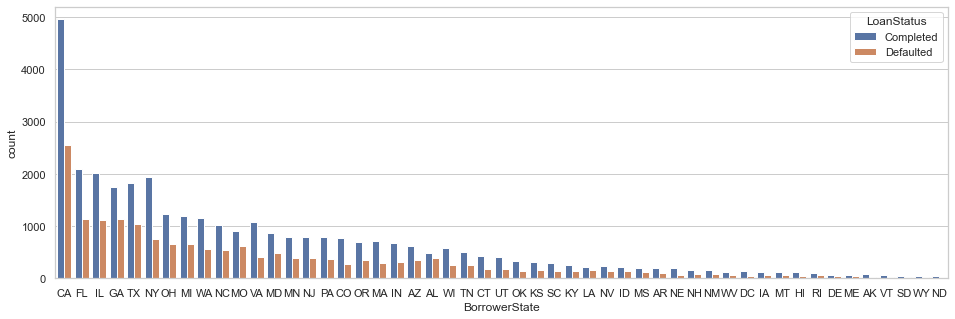

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,5)) 

sns.countplot('BorrowerState',data=df,hue='LoanStatus',
              order =df['BorrowerState'].value_counts().index)

<AxesSubplot:xlabel='EmploymentStatus', ylabel='CreditScore'>

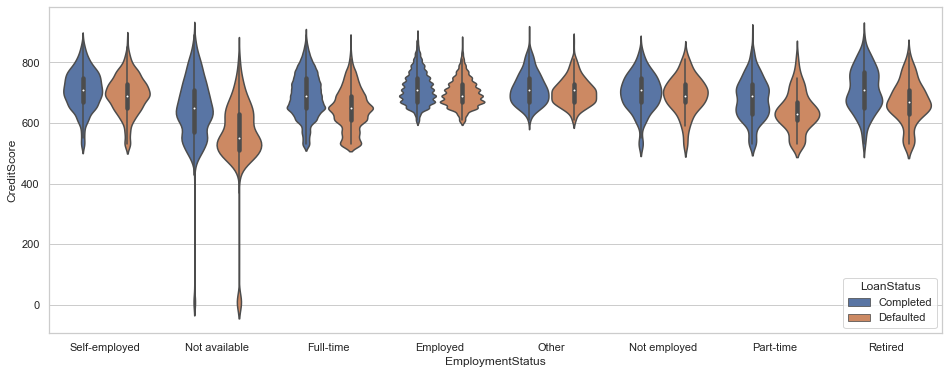

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,6))
sns.violinplot('EmploymentStatus','CreditScore',data=df,hue='LoanStatus')

<AxesSubplot:>

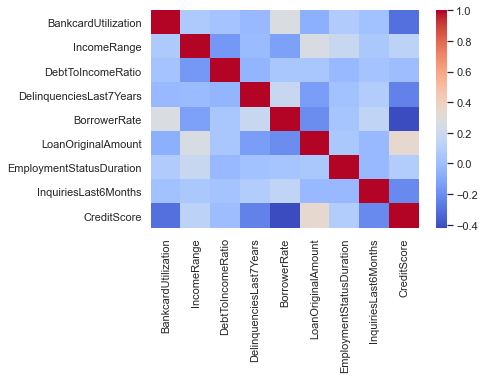

In [23]:
numeric=df[['LoanStatus','BankcardUtilization','IncomeRange','DebtToIncomeRatio',
            'DelinquenciesLast7Years','BorrowerRate','LoanOriginalAmount',
            'EmploymentStatusDuration', 'InquiriesLast6Months', 'CreditScore']]

sns.heatmap(round(numeric.corr(),2),cmap='coolwarm')

### explore the creditGrade

In [24]:
# transfer object type value into numeric value
df["LoanStatus"] = (df["LoanStatus"] == "Completed").astype(int)

df["BorrowerState"] = (df["BorrowerState"]).astype('category')
df["EmploymentStatus"] = (df["EmploymentStatus"]).astype('category')

> #### decision tree

In [25]:
def get_data(df,phase,col):
    
    df=df[df['Phase']== phase]
    
    X=df[['LoanStatus','BankcardUtilization','IncomeRange','DebtToIncomeRatio',
    'DelinquenciesLast7Years','BorrowerRate', 'IsBorrowerHomeowner',
    'LoanOriginalAmount','EmploymentStatusDuration', 'InquiriesLast6Months', 'CreditScore']]
    
    Y=df[col]
    df=pd.concat([X,Y],axis=1)
    
    return df

In [26]:
bf=get_data(df,'Before','CreditGrade')
bf.dropna(how='any',inplace=True)
af=get_data(df,'After','ProsperRating (Alpha)')
af.dropna(how='any',inplace=True)

bf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28948 entries, 0 to 113927
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   LoanStatus                28948 non-null  int64  
 1   BankcardUtilization       28948 non-null  float64
 2   IncomeRange               28948 non-null  float64
 3   DebtToIncomeRatio         28948 non-null  float64
 4   DelinquenciesLast7Years   28948 non-null  float64
 5   BorrowerRate              28948 non-null  float64
 6   IsBorrowerHomeowner       28948 non-null  bool   
 7   LoanOriginalAmount        28948 non-null  int64  
 8   EmploymentStatusDuration  28948 non-null  float64
 9   InquiriesLast6Months      28948 non-null  float64
 10  CreditScore               28948 non-null  float64
 11  CreditGrade               28948 non-null  object 
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 2.7+ MB


In [27]:
from sklearn import tree

def fit_tree(df,col):
    
    X = df.drop(col, axis=1).values

    le = LabelEncoder()
    Y = le.fit_transform(df[col].values)

    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.5, random_state=1)
    
    tree_classifier = tree.DecisionTreeClassifier(criterion = 'entropy')
    tree_classifier = tree_classifier.fit(X_train, Y_train)

    predict = tree_classifier.predict(X_test)
    accuracy = np.mean(predict == Y_test)

    TP,FP,TN,FN,match=0,0,0,0,0
    for i in range(len(Y_test)):
        true_lb=Y_test[i]
        my_lb=predict[i]
        if true_lb == my_lb:
            match+=1
        if (true_lb == 0) & (my_lb == 0):
                TP+=1
        elif (true_lb == 1) & (my_lb == 0):
                FP+=1
        elif (true_lb == 1) & (my_lb == 1):
                TN+=1
        elif (true_lb == 0) & (my_lb == 1):
                FN+=1
        else:
            continue
    TPR=TP/(TP+FN)
    TNR = TN/(TN+FP)
    accuracy=match/len(Y_test)
    dic=[TP,FP,TN,FN,accuracy,TPR,TNR]
    result=pd.DataFrame(dic)
    result.index=['TP','FP','TN','FN','accuracy','TPR','TNR']
    return result

In [28]:
fit_tree(bf,'CreditGrade')

,0
TP,1607.000000
FP,11.000000
TN,1670.000000
FN,12.000000
accuracy,0.985837
TPR,0.992588
TNR,0.993456


In [29]:
fit_tree(af,'ProsperRating (Alpha)')

,0
TP,1625.000000
FP,111.000000
TN,769.000000
FN,114.000000
accuracy,0.836905
TPR,0.934445
TNR,0.873864


> #### random forest

In [30]:
def find_d(data,col):
    X = data[['BankcardUtilization','IncomeRange','DebtToIncomeRatio',
              'DelinquenciesLast7Years','BorrowerRate', 'IsBorrowerHomeowner',
              'LoanOriginalAmount','EmploymentStatusDuration',
              'InquiriesLast6Months', 'CreditScore']].values
    le = LabelEncoder()
    Y = le.fit_transform(data[col].values)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.5, random_state=1)
    df_new = pd.DataFrame(columns=['d=1','d=2','d=3','d=4','d=5',
                                   'd=6','d=7','d=8','d=9','d=10',
                                   'd=11','d=12'],index=range(1,11))
    for i in range(1,11):
        for j in range(1,13):
            X_train, X_test, Y_train, Y_test = train_test_split(X,Y,\
                    test_size=0.5, random_state=11)
            model = RandomForestClassifier(n_estimators =i, max_depth =j,\
                                    criterion ='entropy', random_state=12)
            model.fit(X_train, Y_train )
            prediction = model.predict(X_test)
            error_rate = np.mean(prediction != Y_test)
            df_new.iloc[i-1,j-1] = error_rate

    x=df_new.index
    colors=['lightsteelblue','hotpink','slateblue','darkkhaki','gold',
            'green','moccasin','blue','yellow','orange',
            'red','palegreen']

    plt.figure(figsize=(10,8)) 

    for i in range(0,12):
            plt.plot(x,df_new[df_new.columns[i]],color=colors[i], linewidth=2,
            alpha=1,marker='o',markerfacecolor=colors[i],markersize=6)
            plt.legend(labels = df_new.columns, loc = 'best')        

    plt.title('Random Forest',fontsize=14)
    plt.xticks(np.arange(1, 11, step=1))
    plt.xlabel('number of estimators', fontsize=14)
    plt.ylabel('error rate', fontsize=14)
    plt.grid(alpha= 0.5)
    return

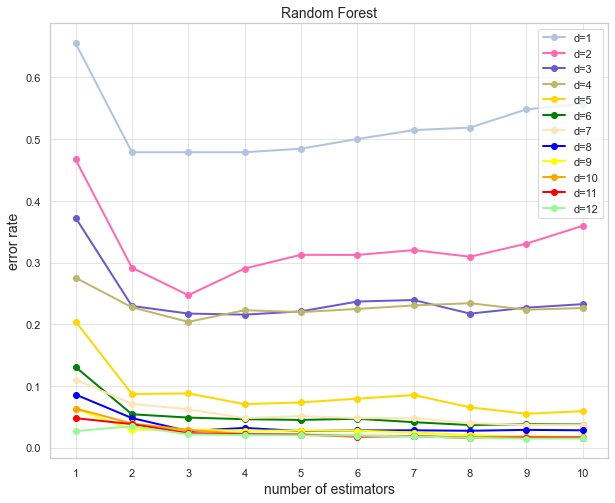

In [31]:
find_d(bf,'CreditGrade')

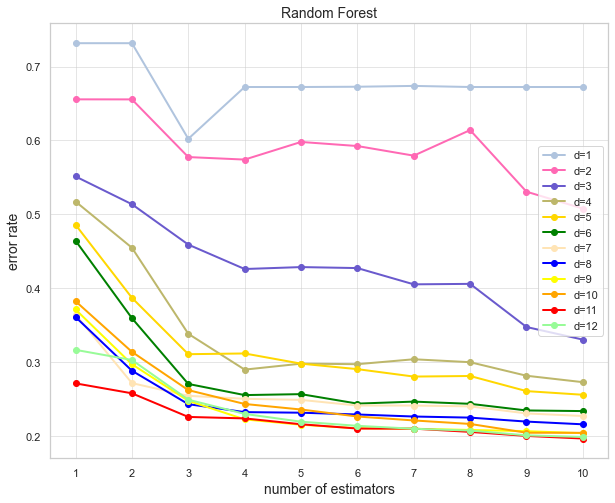

In [32]:
find_d(af,'ProsperRating (Alpha)')

In [33]:
def fit_rf(data,col,n):
    X = data.drop(col, axis=1).values

    le = LabelEncoder()
    Y = le.fit_transform(data[col].values)

    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.5, random_state=1)

    model = RandomForestClassifier(n_estimators =9, max_depth =n,
                                   criterion ='entropy', random_state=1)
    model.fit(X_train, Y_train )
    predict= model.predict(X_test)
    accuracy = np.mean(predict == Y_test)

    TP,FP,TN,FN,match=0,0,0,0,0
    for i in range(len(Y_test)):
        true_lb=Y_test[i]
        my_lb=predict[i]
        if true_lb == my_lb:
            match+=1
        if (true_lb == 0) & (my_lb == 0):
                TP+=1
        elif (true_lb == 1) & (my_lb == 0):
                FP+=1
        elif (true_lb == 1) & (my_lb == 1):
                TN+=1
        elif (true_lb == 0) & (my_lb == 1):
                FN+=1
        else:
            continue
    TPR=TP/(TP+FN)
    TNR = TN/(TN+FP)
    accuracy=match/len(Y_test)
    dic=[TP,FP,TN,FN,accuracy,TPR,TNR]
    result=pd.DataFrame(dic)
    result.index=['TP','FP','TN','FN','accuracy','TPR','TNR']
    return result

In [42]:
fit_rf(bf,'CreditGrade',12)

,0
TP,1598.000000
FP,9.000000
TN,1676.000000
FN,30.000000
accuracy,0.983695
TPR,0.981572
TNR,0.994659


In [45]:
fit_rf(af,'ProsperRating (Alpha)',12)

,0
TP,1587.000000
FP,150.000000
TN,735.000000
FN,135.000000
accuracy,0.786831
TPR,0.921603
TNR,0.830508


In [46]:
res1=fit_tree(bf,'CreditGrade')
res2=fit_tree(af,'ProsperRating (Alpha)')

res_tree=pd.concat([res1,res2],axis=1)

res3=fit_rf(bf,'CreditGrade',11)
res4=fit_rf(af,'ProsperRating (Alpha)',14)

res_rf=pd.concat([res3,res4],axis=1)

res_all=pd.concat([res_tree,res_rf],axis=1).T

res_all.index=['tree_before','tree_after','forest_before','forest_after']
res_all.to_csv('res.csv')
print(res_all)

                   TP     FP      TN     FN  accuracy       TPR       TNR
tree_before    1609.0    8.0  1671.0   10.0  0.986044  0.993823  0.995235
tree_after     1628.0  102.0   780.0  120.0  0.836481  0.931350  0.884354
forest_before  1593.0   20.0  1663.0   24.0  0.976026  0.985158  0.988116
forest_after   1609.0  133.0   753.0  142.0  0.793974  0.918903  0.849887


> #### try to classifiy all data no matter before or after 07-01-2009

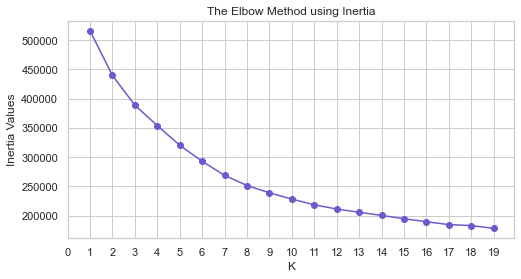

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import  LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix



X = df[['BankcardUtilization',
            'IncomeRange','DebtToIncomeRatio',
            'DelinquenciesLast7Years','BorrowerRate',
            'LoanOriginalAmount','EmploymentStatusDuration',
            'InquiriesLast6Months','CreditScore']].values

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
Y =df['LoanStatus'].values.ravel()

list1 = []
for k in range(1,20):
    kmeans_classifier = KMeans(n_clusters=k)
    y_kmeans = kmeans_classifier.fit_predict(X)
    inertia = kmeans_classifier.inertia_
    list1.append(inertia)


plt.figure(figsize=(8,4))
plt.plot(range(1,20), list1, marker = 'o',color='slateblue')
plt.xticks(range(20))
plt.xlabel('K') 
plt.ylabel('Inertia Values') 
plt.title('The Elbow Method using Inertia')

plt.grid(True)
plt.show()

In [52]:
import statistics

kmeans_classifier = KMeans(n_clusters=7)  
y_kmeans = kmeans_classifier.fit_predict(X)
inertia = kmeans_classifier.inertia_
centroids = kmeans_classifier.cluster_centers_

feature_length = 9
feature_list = np.random.choice(feature_length, 2, replace=False)

entriod = {}
for i in range(1,8):
    label_list = Y[y_kmeans == (i-1)]
    final_label = statistics.mode(label_list)
    centroid = centroids[i-1]
    centroid_name = 'centroid %s'%i
    entriod.update({centroid_name:final_label})

In [49]:
labels = []
for i in range(len(X)):
    d1 = distance.euclidean(X[i],centroids[0])
    d2 = distance.euclidean(X[i],centroids[1])
    d3 = distance.euclidean(X[i],centroids[2])
    d4 = distance.euclidean(X[i],centroids[3])
    d5 = distance.euclidean(X[i],centroids[4])
    d6 = distance.euclidean(X[i],centroids[5])
    d7 = distance.euclidean(X[i],centroids[6])

    l=[d1, d2, d3,d4, d5, d6,d7]
    for n in range(1,8):
        if min(l) == l[n-1]:
            labels.append(entriod['centroid %s'%(n)])    

accuracy= np.mean(np.array(labels) == Y)
print('accuracy for k mean is', round(accuracy,4))

accuracy for k mean is 0.6725


In [51]:
kmeans_classifier = KMeans(n_clusters=8)  
y_kmeans = kmeans_classifier.fit_predict(X)
inertia = kmeans_classifier.inertia_
centroids = kmeans_classifier.cluster_centers_

feature_length = 9
feature_list = np.random.choice(feature_length, 2, replace=False)

entriod = {}
for i in range(1,9):
    label_list = Y[y_kmeans == (i-1)]
    final_label = statistics.mode(label_list)
    centroid = centroids[i-1]
    centroid_name = 'centroid %s'%i
    entriod.update({centroid_name:final_label})
    
labels = []
for i in range(len(X)):
    d1 = distance.euclidean(X[i],centroids[0])
    d2 = distance.euclidean(X[i],centroids[1])
    d3 = distance.euclidean(X[i],centroids[2])
    d4 = distance.euclidean(X[i],centroids[3])
    d5 = distance.euclidean(X[i],centroids[4])
    d6 = distance.euclidean(X[i],centroids[5])
    d7 = distance.euclidean(X[i],centroids[6])
    d8 = distance.euclidean(X[i],centroids[7])

    l=[d1, d2, d3,d4, d5, d6,d7,d8]
    for n in range(1,9):
        if min(l) == l[n-1]:
            labels.append(entriod['centroid %s'%(n)])    

accuracy= np.mean(np.array(labels) == Y)
print('accuracy for k mean is', round(accuracy,4))

accuracy for k mean is 0.6724
